# Capturing and labeling images

In [1]:
import os
import time
import uuid
import cv2

IMAGES_PATH = os.path.join('data','images1')
WORKSPACE_PATH = os.path.join('home','herman','workspace','FaceDetect')

# Create the directory if it doesn't exist
os.makedirs(IMAGES_PATH, exist_ok=True)
number_images=120

In [2]:
cap=cv2.VideoCapture(0)
for imgnum in range(number_images):
    ret, frame=cap.read()
    if not ret:
        print("camera error") 
        break
    imgname=os.path.join(IMAGES_PATH, str(uuid.uuid1())+'.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(1)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

[ WARN:0] global ./modules/videoio/src/cap_gstreamer.cpp (1100) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


In [ ]:
# !labelme

# review dataset and building image loading function

In [5]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [3]:

images = tf.data.Dataset.list_files('data/images/*.jpg')
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

images=images.map(load_image)

type(images)

tensorflow.python.data.ops.map_op._MapDataset

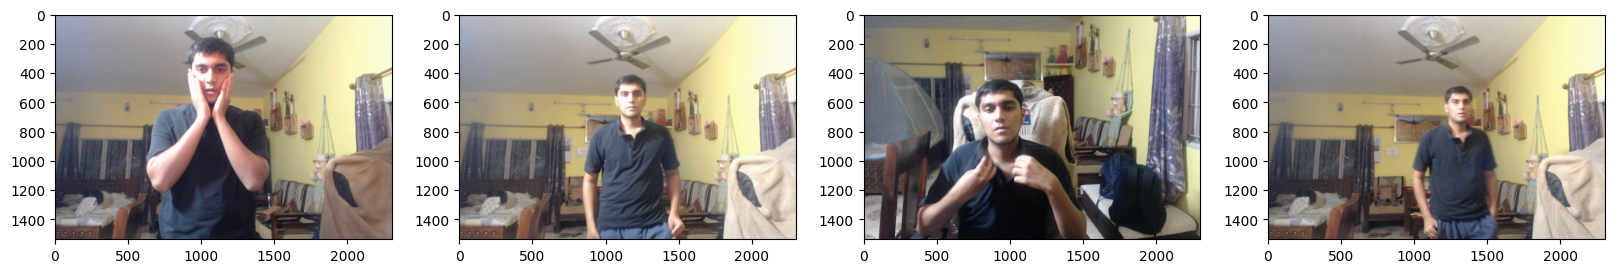

In [4]:
image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# Split data (test,data,validate)

In [4]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# apply albumentations

In [6]:
import albumentations as alb
import cv2
import os
import json
import numpy as np

In [ ]:
# just checking the size of images
for file in os.listdir('/home/herman/workspace/face_detection-recognition/data/images/'):
    imgc=cv2.imread('/home/herman/workspace/face_detection-recognition/data/images/'+file)
    print(imgc.shape)

In [47]:
augmentor = alb.Compose([alb.RandomCrop(width=1300, height=1300), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [48]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [2304, 1536, 2304, 1536]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 

                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)


x_max is less than or equal to x_min for bbox [0.057291666666666616, 0.531467013888889, 0.0008680555555555062, 0.3643663194444444, 'face'].


# Load Albumentations to tensorflow

In [69]:
import tensorflow as tf

In [7]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [8]:
train_images.as_numpy_iterator().next()


array([[[0.2784314 , 0.28235295, 0.29803923],
        [0.27450982, 0.28431374, 0.30294117],
        [0.26685733, 0.28646517, 0.30999458],
        ...,
        [0.30797943, 0.28445002, 0.22954808],
        [0.3019608 , 0.27941176, 0.21372549],
        [0.29049537, 0.27088752, 0.19575164]],

       [[0.24624182, 0.27467322, 0.2893791 ],
        [0.25514707, 0.264951  , 0.28357843],
        [0.27156863, 0.27156863, 0.30294117],
        ...,
        [0.30522892, 0.27034324, 0.24011458],
        [0.2995098 , 0.28039217, 0.20882353],
        [0.29215688, 0.27156863, 0.20784314]],

       [[0.25639978, 0.27208605, 0.27600762],
        [0.25596404, 0.2736111 , 0.2961601 ],
        [0.25653598, 0.26761982, 0.30495644],
        ...,
        [0.3075162 , 0.2918299 , 0.25462934],
        [0.3013889 , 0.29354575, 0.24607843],
        [0.30051723, 0.28875253, 0.22992902]],

       ...,

       [[0.3916936 , 0.38777202, 0.37208575],
        [0.35588187, 0.3539211 , 0.33725443],
        [0.3790038 , 0

# Prepare Lables

In [9]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [10]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [11]:
train_labels.as_numpy_iterator().next()


2024-07-10 08:55:15.477025: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


(array([1], dtype=uint8),
 array([0.47  , 0.3083, 0.7817, 0.6943], dtype=float16))

# cobine label and image samples

In [12]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(4740, 4740, 1200, 1200, 1200, 1200)

In [13]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(6000)
train = train.batch(8)
train = train.prefetch(4)
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1500)
test = test.batch(8)
test = test.prefetch(4)
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1500)
val = val.batch(8)
val = val.prefetch(4)

In [14]:
data_samples = train.as_numpy_iterator()

In [17]:
res = data_samples.next()

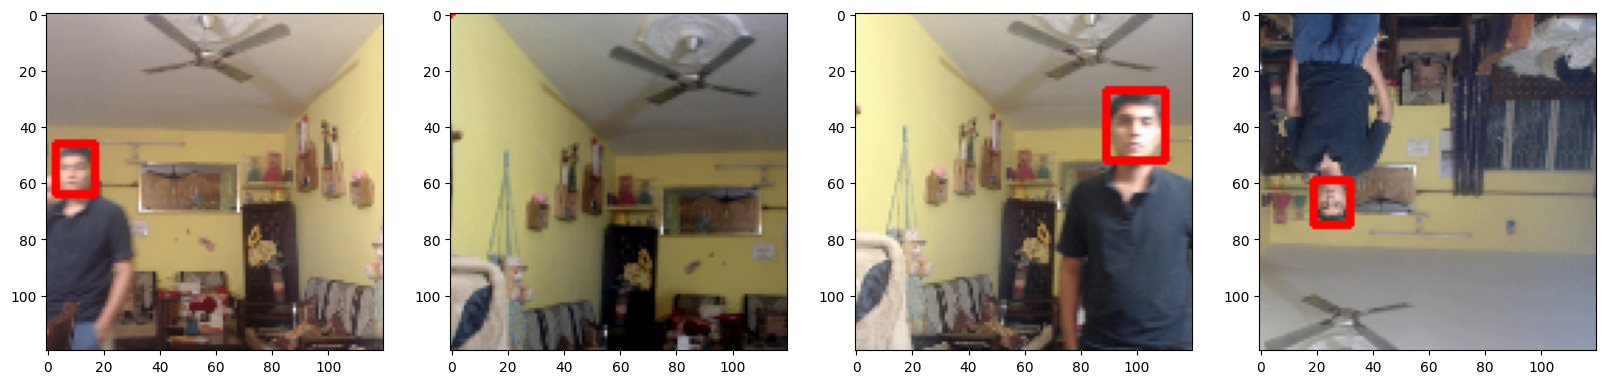

In [18]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# Build Deep Learning using the Functional API

In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [20]:
vgg = VGG16(include_top=False)
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [22]:
facetracker = build_model()
facetracker.summary()
X, y = train.as_numpy_iterator().next()
X.shape

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      2,049 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │      8,196 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

(8, 120, 120, 3)

In [23]:
classes, coords = facetracker.predict(X)
classes, coords

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


(array([[0.367048  ],
        [0.4592557 ],
        [0.34823322],
        [0.42663467],
        [0.38330117],
        [0.3805583 ],
        [0.3647497 ],
        [0.38817874]], dtype=float32),
 array([[0.5658895 , 0.3700197 , 0.45639607, 0.5500554 ],
        [0.5960861 , 0.39481446, 0.42922714, 0.52322924],
        [0.6526457 , 0.43061364, 0.47723243, 0.45350152],
        [0.6558337 , 0.32755533, 0.5032735 , 0.69770503],
        [0.6293529 , 0.4876382 , 0.35721666, 0.46408537],
        [0.67064947, 0.4075328 , 0.49399152, 0.550794  ],
        [0.59253657, 0.47580823, 0.39755642, 0.6081001 ],
        [0.64284277, 0.47993192, 0.43388307, 0.6823398 ]], dtype=float32))

# Define Losses and Optimizers

In [24]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

/home/herman/.local/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [25]:
batches_per_epoch

593

In [26]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [27]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [28]:
# Test out Loss Metrics
localization_loss(y[1], coords)
classloss(y[0], classes)
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.2131324>

# Train Neural Network

In [29]:
class FaceTracker(Model):
  def __init__(self, eyetracker, **kwargs):
    super().__init__(**kwargs)
    self.model = eyetracker

  def compile(self, opt, classloss, localizationloss, **kwargs):
    super().compile(**kwargs)
    self.closs = classloss
    self.lloss = localizationloss
    self.opt = opt

  @tf.function  # Decorate train_step with @tf.function
  def train_step(self, batch, **kwargs):
    X, y = batch

    with tf.GradientTape() as tape:
      try:
        classes, coords = self.model(X, training=True)

        # Ensure y[0] has a defined rank (handle potential reshaping)
        y_0 = tf.reshape(y[0], [-1, 1])  # Example: Reshape to (batch_size,1) if needed
        # Check your data format and reshape accordingly

        # Ensure classes has a defined rank (check model output shape)
        # ... (reshape classes if necessary based on your model's output)

        batch_classloss = self.closs(y_0, classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32),
coords)
        total_loss = batch_localizationloss + 0.5 * batch_classloss

      except tf.errors.InvalidArgumentError as e:
        # Handle the case where y[0] might have a batch size of zero(optional)
        if 'Input tensors must be of size at least 1' in str(e):
          return {"total_loss": tf.constant(0.0)}  # Dummy loss (optional)
        else:
          raise e  # Re-raise other errors

      grad = tape.gradient(total_loss, self.model.trainable_variables)
      self.opt.apply_gradients(zip(grad, self.model.trainable_variables))

    return {"total_loss": total_loss, "class_loss": batch_classloss,
"regress_loss": batch_localizationloss}

  def test_step(self, batch, **kwargs):
    X, y = batch
    classes, coords = self.model(X, training=False)

    # Ensure y[0] has a defined rank (handle potential reshaping)
    y_0 = tf.reshape(y[0], [-1, 1])  # Example: Reshape to (batch_size, 1)if needed
    # Check your data format and reshape accordingly

    # Ensure classes has a defined rank (check model output shape)
    # ... (reshape classes if necessary based on your model's output)

    batch_classloss = self.closs(y_0, classes)
    batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
    total_loss = batch_localizationloss + 0.5 * batch_classloss
    return {"total_loss": total_loss, "class_loss": batch_classloss,
"regress_loss": batch_localizationloss}

  def call(self, X, **kwargs):
    return self.model(X, **kwargs)

In [30]:
model = FaceTracker(facetracker)
model.compile(opt, classloss, regressloss)

In [31]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [32]:

hist = model.fit(train, epochs=5, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/5


I0000 00:00:1720582064.527995    5096 service.cc:145] XLA service 0x7702c8006380 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720582064.528019    5096 service.cc:153]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1720582064.575800    5096 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


593/593 ━━━━━━━━━━━━━━━━━━━━ 466s 771ms/step - class_loss: 0.0736 - regress_loss: 0.2499 - total_loss: 0.2867 - val_class_loss: 0.0021 - val_regress_loss: 0.0368 - val_total_loss: 0.0378
Epoch 2/5
593/593 ━━━━━━━━━━━━━━━━━━━━ 495s 825ms/step - class_loss: 0.0318 - regress_loss: 0.0865 - total_loss: 0.1024 - val_class_loss: 0.0243 - val_regress_loss: 0.1237 - val_total_loss: 0.1358
Epoch 3/5
593/593 ━━━━━━━━━━━━━━━━━━━━ 491s 814ms/step - class_loss: 0.0243 - regress_loss: 0.0753 - total_loss: 0.0875 - val_class_loss: 4.6514e-04 - val_regress_loss: 0.1535 - val_total_loss: 0.1538
Epoch 4/5
593/593 ━━━━━━━━━━━━━━━━━━━━ 499s 830ms/step - class_loss: 0.0278 - regress_loss: 0.0792 - total_loss: 0.0931 - val_class_loss: 0.0011 - val_regress_loss: 0.1536 - val_total_loss: 0.1541
Epoch 5/5
593/593 ━━━━━━━━━━━━━━━━━━━━ 501s 834ms/step - class_loss: 0.0213 - regress_loss: 0.0512 - total_loss: 0.0618 - val_class_loss: 0.0025 - val_regress_loss: 0.0630 - val_total_loss: 0.0643


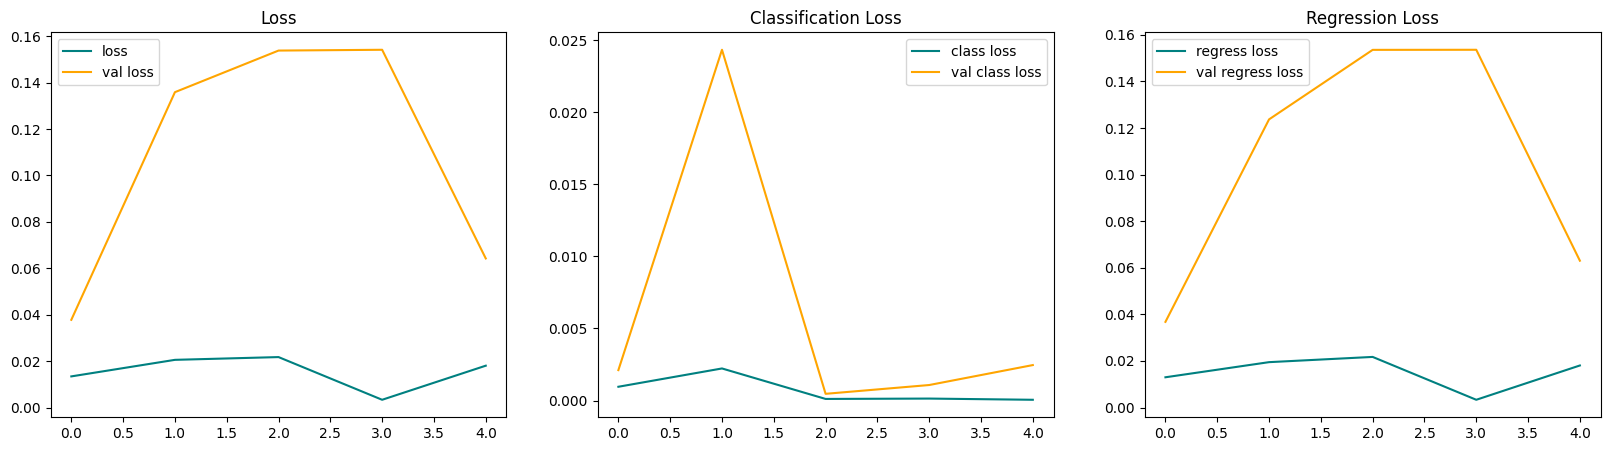

In [35]:
# checking the performance of the model
# hist.history

fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# Make predictions on the test part

In [36]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = facetracker.predict(test_sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


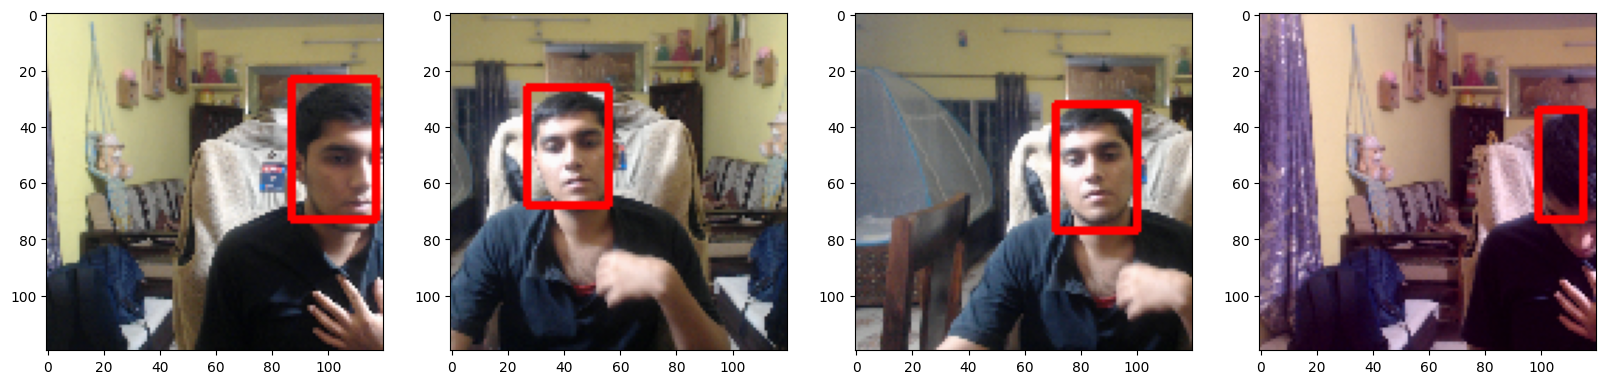

In [37]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [38]:
from tensorflow.keras.models import load_model
facetracker.save('facetracker.h5')
facetracker = load_model('facetracker.h5')

In [48]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    # frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [2800,2800]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [2800,2800]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [2800,2800]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [2800,2800]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [2800,2800]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

[ WARN:0] global ./modules/videoio/src/cap_gstreamer.cpp (1100) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━

KeyboardInterrupt: 

: 